# Testing code for project segments

#### CVAR test

In [1]:
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
from scipy.stats import norm, chi2

from swarm_prm.solvers.swarm_prm.macro.gaussian_prm import GaussianNode
from swarm_prm.envs.map import Map, Obstacle 


def obstacle_gaussian_collision(obs: Obstacle, g_node: GaussianNode, alpha, thresh, ax) -> bool:
    """
        Using CVaR and threshold to test if node is too close to obstacle.
        Return True if CVaR is greater than the threshold.
        Reference: SwarmPRM
    """

    # Plot normal vector
    mean = -obs.get_dist(g_node.get_mean())
    v_normal = (obs.pos - g_node.get_mean()) / (np.linalg.norm(obs.pos - g_node.get_mean()))
    start_pos = g_node.get_mean()
    end_pos = start_pos - v_normal * mean
    vec = np.vstack([start_pos, end_pos]).T
    ax.plot(vec[0], vec[1])

    variance = v_normal.T @ g_node.covariance @ v_normal
    ita = norm(mean, variance)
    cvar = mean + ita.pdf(ita.ppf(1-alpha))/alpha * variance
    # print(cvar)
    return cvar > thresh

def visualize_g_node(g_node, ax, thresh, is_collision):
    # Visualize G nodes
    mean, cov = g_node.get_gaussian()
    # Compute the eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(cov)

    # Sort eigenvalues and eigenvectors by descending eigenvalue
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]

    # The angle of the ellipse (in degrees)
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

    # The width and height of the ellipse (2*sqrt(chi2_value*eigenvalue))
    chi2_value = chi2.ppf(thresh, 2)  # threshold confidence interval for 2 degrees of freedom (chi-squared value)
    width, height = 2 * np.sqrt(chi2_value * eigenvalues)
    if is_collision:
        ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, 
                          edgecolor="red", fc='None', lw=2)
    else:
        ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, 
                          edgecolor="blue", fc='None', lw=2)
    ax.add_patch(ellipse)


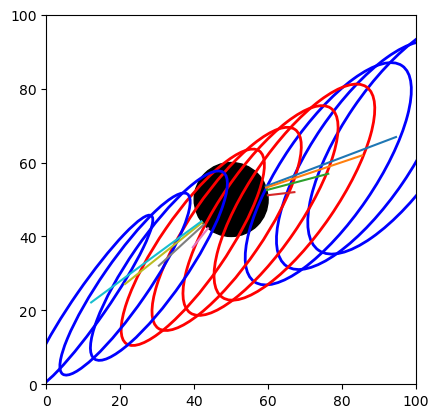

In [2]:
roadmap = Map(100, 100)
pos = np.array([50, 50])
obs = Obstacle(pos, "CIRCLE", 10)
thresh = -8
tolerance = 0.95
alpha = 0.95 
num_g_node = 10 

roadmap.add_obstacle(obs)
fig, ax = roadmap.visualize()
start_mean = np.random.rand(2) * 100
goal_mean = np.random.rand(2) * 100

temp = np.random.rand(2, 2) * 10
start_cov =  temp @ temp.T
temp = np.random.rand(2, 2) * 10
goal_cov =  temp @ temp.T

for i in range(num_g_node):
    mean = i / (num_g_node) * start_mean + (num_g_node - i) / num_g_node * goal_mean
    cov = i / (num_g_node) * start_cov + (num_g_node - i) / num_g_node * goal_cov

    g_node = GaussianNode(mean, cov)
    is_collision = obstacle_gaussian_collision(obs,  g_node, alpha, thresh, ax)
    visualize_g_node(g_node, ax, tolerance, is_collision)

## Voronoi Diagram

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import Polygon, Point, LineString, MultiPoint

def compute_voronoi(points, bounding_polygon):
    """
    Compute Voronoi diagram clipped by a bounding polygon.
    """
    vor = Voronoi(points)
    regions = []
    for region_index in vor.regions:
        if not region_index or -1 in region_index:
            continue
        polygon_points = [vor.vertices[i] for i in region_index]
        voronoi_polygon = Polygon(polygon_points)
        if bounding_polygon.contains(voronoi_polygon):
            regions.append(voronoi_polygon.intersection(bounding_polygon))
        else:
            regions.append(None)
    return vor, regions

def compute_centroids(regions):
    """
    Compute centroids of the Voronoi cells.
    """
    centroids = []
    for region in regions:
        if region and not region.is_empty:
            centroids.append(region.centroid.coords[0])
    return np.array(centroids)

def compute_voronoi_with_clipping(points, bounding_polygon):
    """
    Compute Voronoi diagram clipped by a bounding polygon.
    """
    vor = Voronoi(points)
    new_regions = []
    new_vertices = [tuple(v) for v in vor.vertices]  # Convert vertices to tuples

    # Map infinite regions to the boundary polygon
    for region_index in vor.regions:
        if not region_index or -1 in region_index:
            # Handle infinite regions
            region = [v for v in region_index if v != -1]
            if not region:
                continue
            
            # Start with finite vertices
            new_region = [tuple(vor.vertices[v]) for v in region]  # Convert to tuples
            
            # Find the ridges that go to infinity
            for pointidx, simplex in zip(vor.ridge_points, vor.ridge_vertices):
                simplex = np.asarray(simplex)
                if np.any(simplex < 0):  # Infinite ridge
                    i = simplex[simplex >= 0][0]  # Finite endpoint of the ridge
                    
                    # Direction of the line from the finite point towards infinity
                    t = vor.points[pointidx[1]] - vor.points[pointidx[0]]  # tangent
                    t = t / np.linalg.norm(t)
                    n = np.array([-t[1], t[0]])  # normal vector

                    # Compute a point far away in the direction of the normal
                    far_point = vor.vertices[i] + n * 1000

                    # Clip the line with the bounding polygon
                    line = LineString([vor.vertices[i], far_point])
                    clipped_line = line.intersection(bounding_polygon)
                    
                    if not clipped_line.is_empty:
                        # Handle different types of intersections (Point, MultiPoint)
                        if isinstance(clipped_line, MultiPoint):
                            for point in clipped_line:
                                point_tuple = tuple(point.coords[0])
                                if point_tuple not in new_vertices:
                                    new_region.append(point_tuple)
                                    new_vertices.append(point_tuple)
                        elif isinstance(clipped_line, Point):
                            point_tuple = tuple(clipped_line.coords[0])
                            if point_tuple not in new_vertices:
                                new_region.append(point_tuple)
                                new_vertices.append(point_tuple)
            
            # Convert back to indices
            new_region = [new_vertices.index(vertex) for vertex in new_region]
            new_regions.append(new_region)
        else:
            # Handle finite regions
            new_regions.append(region_index)
    
    return new_regions, np.array(new_vertices)

def plot_voronoi_with_clipping(voronoi, regions, vertices, obstacles, bounding_polygon):
    """
    Plot Voronoi diagram with the clipped regions for infinite cells.
    """
    plt.figure(figsize=(10, 10))

    # Plot each valid Voronoi region
    for region in regions:
        polygon_points = [vertices[i] for i in region]

        # Ensure valid polygon has at least 4 points and forms a closed loop
        if len(polygon_points) < 3:
            continue  # Skip if not enough points to form a polygon

        if len(polygon_points) >= 3 and polygon_points[0][0] != polygon_points[-1][0] and polygon_points[0][1] != polygon_points[-1][1]:
            polygon_points.append(polygon_points[0])  # Close the loop if needed
        
        if len(polygon_points) < 4:
            continue  # Ensure the polygon is valid

        voronoi_polygon = Polygon(polygon_points)
        
        # Clip the Voronoi cell with the bounding polygon
        voronoi_polygon = voronoi_polygon.intersection(bounding_polygon)
        
        # Exclude regions that overlap with obstacles
        if voronoi_polygon.is_empty or any(voronoi_polygon.intersects(obs) for obs in obstacles):
            continue
        
        # Plot the Voronoi cell
        x, y = voronoi_polygon.exterior.xy
        plt.fill(x, y, alpha=0.4, edgecolor='k')

    # Plot original Voronoi sites
    plt.plot(voronoi.points[:, 0], voronoi.points[:, 1], 'ro')

    # Plot obstacles
    for obs in obstacles:
        x, y = obs.exterior.xy
        plt.fill(x, y, color='gray', alpha=0.7)

    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("Voronoi Diagram with Clipped Infinite Regions")
    plt.show()

# Generate random initial points (Voronoi sites)


In [4]:
num_samples = 500
num_iterations = 100

np.random.seed(42)
points = np.random.rand(num_samples, 2) * 100  # 20 random points in a 100x100 space

# Define obstacles (rectangular polygons for simplicity)
obstacles = [
    Polygon([(20, 20), (20, 40), (40, 40), (40, 20)]),  # Obstacle 1
    Polygon([(60, 60), (60, 80), (80, 80), (80, 60)]),  # Obstacle 2
]

# Bounding polygon to limit Voronoi diagram to a finite area
bounding_polygon = Polygon([(0, 0), (0, 100), (100, 100), (100, 0)])

# Compute Voronoi diagram with infinite regions clipped
for i in range(num_iterations):
    vor, regions = compute_voronoi(points, bounding_polygon)
    centroids = compute_centroids(regions) # Compute centroids of the Voronoi cells
    points = centroids # Update points to centroids

voronoi = Voronoi(points)
regions, vertices = compute_voronoi_with_clipping(points, bounding_polygon)

# Plot the resulting Voronoi diagram after clipping
plot_voronoi_with_clipping(voronoi, regions, vertices, obstacles, bounding_polygon)


ValueError: Input points array must have 2 dimensions.


### CVT test

51


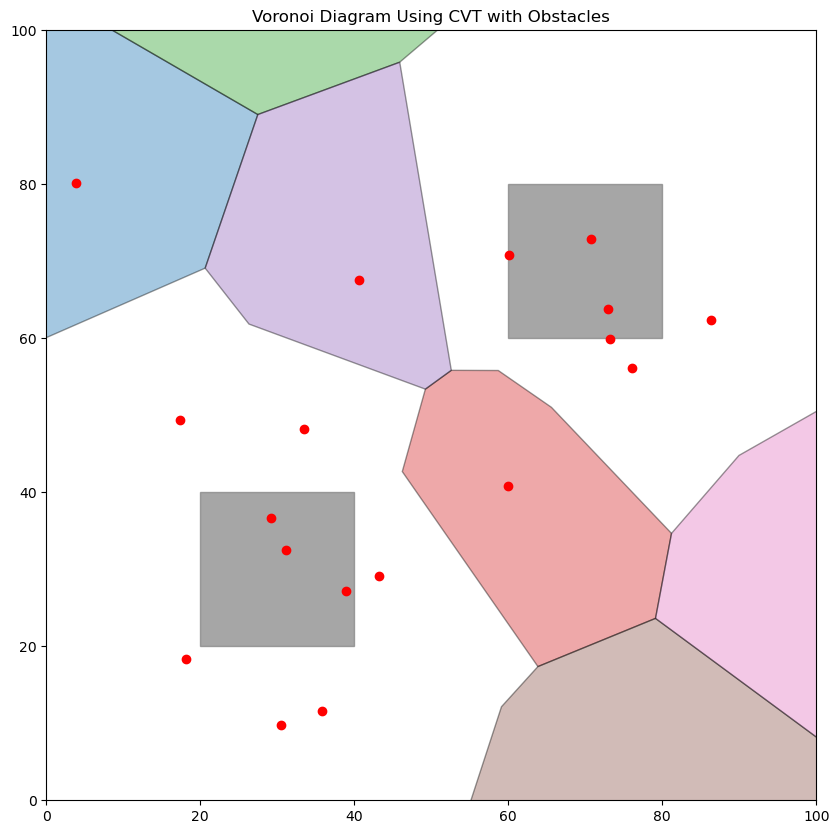

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import Polygon, Point, MultiPolygon
from shapely.ops import unary_union

def compute_voronoi(points):
    """
    Compute Voronoi diagram for given points.
    """
    return Voronoi(points)

def compute_centroids(vor, points, obstacles):
    """
    Compute centroids of the Voronoi cells that do not intersect with obstacles.
    Keep original points for cells that do intersect.
    """
    new_points = []
    for point, region_index in zip(points, vor.point_region):
        region = vor.regions[region_index]
        if not region or -1 in region:
            new_points.append(point)  # Keep original point for infinite regions
            continue
        
        # Create a polygon for the Voronoi cell
        region_vertices = [vor.vertices[i] for i in region]
        cell_polygon = Polygon(region_vertices)
        
        # If the region intersects with any obstacle, keep the original point
        if any(cell_polygon.intersects(obs) for obs in obstacles):
            new_points.append(point)
        else:
            # Calculate the centroid of the cell
            if cell_polygon.is_valid and not cell_polygon.is_empty:
                new_points.append(cell_polygon.centroid.coords[0])
            else:
                new_points.append(point)  # Fallback to original point if invalid
    
    return np.array(new_points)

def plot_voronoi(voronoi, obstacles):
    """
    Plot Voronoi diagram with obstacles.
    """
    plt.figure(figsize=(10, 10))

    # Plot Voronoi cells
    for region_index in voronoi.regions:
        if not region_index or -1 in region_index:
            continue  # Skip infinite regions
        
        region = [voronoi.vertices[i] for i in region_index]
        cell_polygon = Polygon(region)
        
        # Skip regions that intersect with any obstacle
        if any(cell_polygon.intersects(obs) for obs in obstacles):
            continue
        
        # Plot the Voronoi cell
        if cell_polygon.is_valid and not cell_polygon.is_empty:
            x, y = cell_polygon.exterior.xy
            plt.fill(x, y, alpha=0.4, edgecolor='k')

    # Plot Voronoi sites
    plt.plot(voronoi.points[:, 0], voronoi.points[:, 1], 'ro')

    # Plot obstacles
    for obs in obstacles:
        x, y = obs.exterior.xy
        plt.fill(x, y, color='gray', alpha=0.7)

    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("Voronoi Diagram Using CVT with Obstacles")
    plt.show()

# Generate random initial points (Voronoi sites)
np.random.seed(42)
points = np.random.rand(50, 2) * 100  # 30 random points in a 100x100 space

# Define obstacles (rectangular polygons for simplicity)
obstacles = [
    Polygon([(20, 20), (20, 40), (40, 40), (40, 20)]),  # Obstacle 1
    Polygon([(60, 60), (60, 80), (80, 80), (80, 60)]),  # Obstacle 2
]

# Perform Centroidal Voronoi Tessellation
iterations = 10
for i in range(iterations):
    # Compute Voronoi diagram
    voronoi = compute_voronoi(points)
    
    # Compute centroids of the Voronoi cells not intersecting with obstacles
    points = compute_centroids(voronoi, points, obstacles)

print(len(voronoi.regions))
# Plot the resulting Voronoi diagram after CVT
plot_voronoi(voronoi, obstacles)



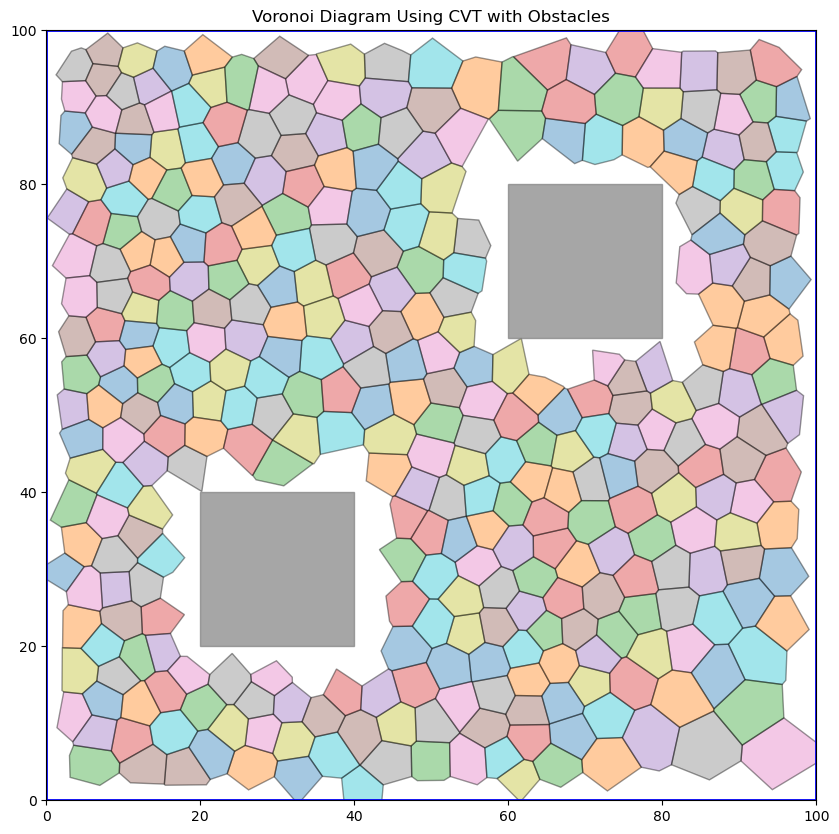

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import Polygon, Point, MultiPolygon
from shapely.ops import unary_union

def compute_voronoi(points):
    """
    Compute Voronoi diagram for given points.
    """
    return Voronoi(points)

def compute_centroids(vor, points, bounding_polygon, obstacles):
    """
    Compute centroids of the Voronoi cells that do not intersect with obstacles.
    Keep original points for cells that do intersect or go outside the bounding polygon.
    """
    new_points = []
    for point, region_index in zip(points, vor.point_region):
        region = vor.regions[region_index]
        if not region or -1 in region:
            new_points.append(point)  # Keep original point for infinite regions
            continue
        
        # Create a polygon for the Voronoi cell
        region_vertices = [vor.vertices[i] for i in region]
        cell_polygon = Polygon(region_vertices)
        
        # If the region intersects with any obstacle, keep the original point
        if any(cell_polygon.intersects(obs) for obs in obstacles):
            new_points.append(point)
        else:
            # Calculate the centroid of the cell
            if cell_polygon.is_valid and not cell_polygon.is_empty:
                centroid = cell_polygon.centroid
                # Ensure the centroid is inside the bounding polygon
                if bounding_polygon.contains(centroid):
                    new_points.append(centroid.coords[0])
                else:
                    # If centroid is outside, keep the original point
                    # Alternatively, you could project it back onto the bounding polygon boundary
                    closest_point = bounding_polygon.exterior.interpolate(bounding_polygon.exterior.project(centroid))
                    new_points.append(closest_point.coords[0])
            else:
                new_points.append(point)  # Fallback to original point if invalid
    
    return np.array(new_points)

def plot_voronoi(voronoi, bounding_polygon, obstacles):
    """
    Plot Voronoi diagram with obstacles.
    """
    plt.figure(figsize=(10, 10))

    # Plot Voronoi cells
    for region_index in voronoi.regions:
        if not region_index or -1 in region_index:
            continue  # Skip infinite regions
        
        region = [voronoi.vertices[i] for i in region_index]
        cell_polygon = Polygon(region)
        
        # Skip regions that intersect with any obstacle
        if any(cell_polygon.intersects(obs) for obs in obstacles):
            continue
        
        # Plot the Voronoi cell
        if cell_polygon.is_valid and not cell_polygon.is_empty:
            x, y = cell_polygon.exterior.xy
            plt.fill(x, y, alpha=0.4, edgecolor='k')

    # Plot Voronoi sites
    # plt.plot(voronoi.points[:, 0], voronoi.points[:, 1], 'ro')

    # Plot bounding polygon
    x, y = bounding_polygon.exterior.xy
    plt.plot(x, y, 'b-', lw=2)

    # Plot obstacles
    for obs in obstacles:
        x, y = obs.exterior.xy
        plt.fill(x, y, color='gray', alpha=0.7)

    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("Voronoi Diagram Using CVT with Obstacles")
    plt.show()

# Generate random initial points (Voronoi sites)
np.random.seed(42)
points = np.random.rand(500, 2) * 100  # 30 random points in a 100x100 space

# Define bounding polygon (a rectangular boundary)
bounding_polygon = Polygon([(0, 0), (0, 100), (100, 100), (100, 0)])

# Define obstacles (rectangular polygons for simplicity)
obstacles = [
    Polygon([(20, 20), (20, 40), (40, 40), (40, 20)]),  # Obstacle 1
    Polygon([(60, 60), (60, 80), (80, 80), (80, 60)]),  # Obstacle 2
]

# Perform Centroidal Voronoi Tessellation
iterations = 10
for i in range(iterations):
    # Compute Voronoi diagram
    voronoi = compute_voronoi(points)
    
    # Compute centroids of the Voronoi cells not intersecting with obstacles, constrained to the bounding polygon
    points = compute_centroids(voronoi, points, bounding_polygon, obstacles)

voronoi = compute_voronoi(points)
# Plot the resulting Voronoi diagram after CVT
plot_voronoi(voronoi, bounding_polygon, obstacles)


### IRIS python version

In [1]:
import numpy as np
import cvxpy as cp
from scipy.spatial import ConvexHull

# Function to compute separating hyperplanes
def find_separating_hyperplanes(C, d, obstacles):
    A = []
    b = []
    for obstacle in obstacles:
        # Transform obstacle points into the space of the ellipsoid
        transformed_obstacle = np.dot(np.linalg.inv(C), (obstacle - d).T).T
        
        # Find the closest point to the origin in transformed space
        hull = ConvexHull(transformed_obstacle)
        closest_point = None
        min_dist = float('inf')
        for simplex in hull.simplices:
            point = transformed_obstacle[simplex].mean(axis=0)
            dist = np.linalg.norm(point)
            if dist < min_dist:
                min_dist = dist
                closest_point = point
        
        # Compute tangent plane in original space
        x_star = np.dot(C, closest_point) + d
        a_j = 2 * np.dot(np.linalg.inv(C).T, (x_star - d))
        b_j = np.dot(a_j, x_star)
        
        A.append(a_j)
        b.append(b_j)
    
    return np.array(A), np.array(b)

# Function to compute the maximum-volume ellipsoid
def find_maximum_ellipsoid(A, b):
    n = A.shape[1]
    C = cp.Variable((n, n), symmetric=True)
    d = cp.Variable(n)

    constraints = [C >> 0]  # C must be positive semidefinite
    for i in range(A.shape[0]):
        constraints.append(cp.norm(A[i] @ C) + A[i] @ d <= b[i])

    # Objective: maximize the log determinant of C (proportional to volume)
    obj = cp.Maximize(cp.log_det(C))
    prob = cp.Problem(obj, constraints)
    prob.solve()

    return C.value, d.value

# Main IRIS algorithm
def iris_algorithm(initial_point, obstacles, tolerance=1e-3, max_iterations=100):
    n = initial_point.shape[0]
    C = np.eye(n) * 1e-3  # Small initial ellipsoid
    d = initial_point

    for i in range(max_iterations):
        # Find separating hyperplanes
        A, b = find_separating_hyperplanes(C, d, obstacles)
        
        # Compute the maximum ellipsoid inscribed in the polytope
        C_new, d_new = find_maximum_ellipsoid(A, b)
        
        # Check for convergence
        if np.abs(np.linalg.det(C_new) - np.linalg.det(C)) / np.linalg.det(C) < tolerance:
            break
        
        C, d = C_new, d_new

    return C, d, A, b

# Example usage
if __name__ == "__main__":
    # Define some example obstacles as convex sets of points
    obstacles = [
        np.array([[2, 2], [3, 2], [3, 3], [2, 3]]),  # Square obstacle
        np.array([[5, 5], [6, 5], [6, 6], [5, 6]])   # Another square obstacle
    ]
    
    # Define the initial point (inside the free space)
    initial_point = np.array([1.0, 1.0])

    # Run the IRIS algorithm
    C, d, A, b = iris_algorithm(initial_point, obstacles)

    # Output results
    print("Maximal ellipsoid matrix (C):\n", C)
    print("Ellipsoid center (d):\n", d)
    print("Separating hyperplanes (A):\n", A)
    print("Hyperplane offsets (b):\n", b)


(CVXPY) Sep 20 05:45:53 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Sep 20 05:45:53 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.10.4067). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


/localhome/zma40/miniconda3/envs/SwarmPRM/lib/python3.12/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Maximal ellipsoid matrix (C):
 [[ 308032.99482359 -114737.24059068]
 [-114737.24059068  332929.22097299]]
Ellipsoid center (d):
 [-148433.52875441 -154376.10079327]
Separating hyperplanes (A):
 [[1.50201562 1.44503486]
 [1.50204567 1.44506323]]
Hyperplane offsets (b):
 [ 6.61661838 15.45807613]


/localhome/zma40/miniconda3/envs/SwarmPRM/lib/python3.12/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


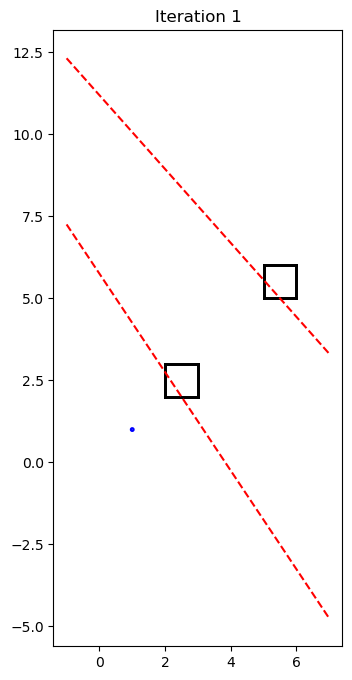

In [2]:
import numpy as np
import cvxpy as cp
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# Function to compute separating hyperplanes
def find_separating_hyperplanes(C, d, obstacles):
    A = []
    b = []
    for obstacle in obstacles:
        # Transform obstacle points into the space of the ellipsoid
        transformed_obstacle = np.dot(np.linalg.inv(C), (obstacle - d).T).T
        
        # Find the closest point to the origin in transformed space
        hull = ConvexHull(transformed_obstacle)
        closest_point = None
        min_dist = float('inf')
        for simplex in hull.simplices:
            point = transformed_obstacle[simplex].mean(axis=0)
            dist = np.linalg.norm(point)
            if dist < min_dist:
                min_dist = dist
                closest_point = point
        
        # Compute tangent plane in original space
        x_star = np.dot(C, closest_point) + d
        a_j = 2 * np.dot(np.linalg.inv(C).T, (x_star - d))
        b_j = np.dot(a_j, x_star)
        
        A.append(a_j)
        b.append(b_j)
    
    return np.array(A), np.array(b)

# Function to compute the maximum-volume ellipsoid
def find_maximum_ellipsoid(A, b):
    n = A.shape[1]
    C = cp.Variable((n, n), symmetric=True)
    d = cp.Variable(n)

    constraints = [C >> 0]  # C must be positive semidefinite
    for i in range(A.shape[0]):
        constraints.append(cp.norm(A[i] @ C) + A[i] @ d <= b[i])

    # Objective: maximize the log determinant of C (proportional to volume)
    obj = cp.Maximize(cp.log_det(C))
    prob = cp.Problem(obj, constraints)
    prob.solve()

    return C.value, d.value

# Function to plot the ellipsoid
def plot_ellipsoid(ax, C, d, color='blue', label=''):
    # Extract ellipsoid parameters
    U, s, Vt = np.linalg.svd(C)
    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    width, height = 2 * np.sqrt(s)
    
    # Create ellipsoid patch
    ell = Ellipse(xy=d, width=width, height=height, angle=angle, edgecolor=color, facecolor='none', lw=2, label=label)
    ax.add_patch(ell)

# Function to plot the obstacles and hyperplanes
def plot_obstacles(ax, obstacles, A=None, b=None):
    for obstacle in obstacles:
        hull = ConvexHull(obstacle)
        for simplex in hull.simplices:
            ax.plot(obstacle[simplex, 0], obstacle[simplex, 1], 'k-', lw=2)

    if A is not None and b is not None:
        x_vals = np.linspace(-1, 7, 100)
        for i in range(A.shape[0]):
            y_vals = (b[i] - A[i, 0] * x_vals) / A[i, 1]
            ax.plot(x_vals, y_vals, 'r--')

# Main IRIS algorithm with visualization
def iris_algorithm_with_visualization(initial_point, obstacles, tolerance=1e-3, max_iterations=10):
    n = initial_point.shape[0]
    C = np.eye(n) * 1e-3  # Small initial ellipsoid
    d = initial_point

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(-1, 7)
    ax.set_ylim(-1, 7)
    ax.set_aspect('equal')

    for i in range(max_iterations):
        ax.clear()
        ax.set_title(f"Iteration {i+1}")
        plot_obstacles(ax, obstacles)
        
        # Plot current ellipsoid
        plot_ellipsoid(ax, C, d, color='blue', label=f'Ellipsoid {i+1}')
        
        # Find separating hyperplanes
        A, b = find_separating_hyperplanes(C, d, obstacles)
        
        # Plot the separating hyperplanes
        plot_obstacles(ax, obstacles, A, b)
        
        # Compute the maximum ellipsoid inscribed in the polytope
        C_new, d_new = find_maximum_ellipsoid(A, b)
        
        # Check for convergence
        if np.abs(np.linalg.det(C_new) - np.linalg.det(C)) / np.linalg.det(C) < tolerance:
            break
        
        C, d = C_new, d_new
        
        # Pause to visualize the current iteration
        plt.pause(1)

    plt.show()

# Example usage
if __name__ == "__main__":
    # Define some example obstacles as convex sets of points
    obstacles = [
        np.array([[2, 2], [3, 2], [3, 3], [2, 3]]),  # Square obstacle
        np.array([[5, 5], [6, 5], [6, 6], [5, 6]])   # Another square obstacle
    ]
    
    # Define the initial point (inside the free space)
    initial_point = np.array([1.0, 1.0])

    # Run the IRIS algorithm with visualization
    iris_algorithm_with_visualization(initial_point, obstacles)


/tmp/ipykernel_1028011/9015080.py:82: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(frame_path))


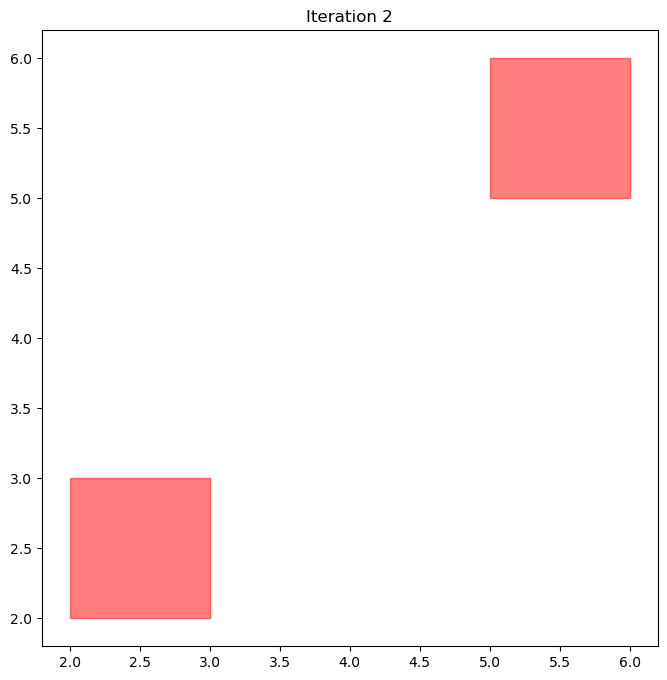

In [2]:
import numpy as np
from shapely.geometry import Polygon, Point
from shapely.affinity import scale, rotate
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import imageio

# Helper function to generate an ellipsoid as a Shapely shape
def generate_ellipsoid(center, radii, angle):
    circle = Point(center).buffer(1)  # Generate unit circle
    ellipsoid = scale(circle, radii[0], radii[1])  # Scale circle into an ellipsoid
    ellipsoid = rotate(ellipsoid, angle)
    return ellipsoid

# Function to compute separating hyperplanes using Shapely
def find_separating_hyperplanes(ellipsoid, obstacles):
    hyperplanes = []
    for obstacle in obstacles:
        # Compute the tangent line between the ellipsoid and the obstacle
        if ellipsoid.intersects(obstacle):
            # Find the intersection points and compute the separating plane
            tangent = ellipsoid.intersection(obstacle)
            # Add logic to compute separating hyperplanes (simple approximation here)
            hyperplanes.append(tangent)
    return hyperplanes

# Objective function: we try to maximize the area (proxy for volume in 2D) of the ellipsoid
def objective(params):
    center = params[:2]
    radii = params[2:]
    ellipsoid = generate_ellipsoid(center, radii)
    return -ellipsoid.area  # We minimize the negative of the area to maximize it

# Constraints: ensure the ellipsoid does not intersect with any obstacles
def constraint(params, obstacles):
    center = params[:2]
    radii = params[2:]
    ellipsoid = generate_ellipsoid(center, radii)
    for obstacle in obstacles:
        if ellipsoid.intersects(obstacle):
            return -1  # Violation: intersection detected
    return 1  # No intersection

# Function to visualize ellipsoid and obstacles
def plot_ellipsoid(ax, ellipsoid, color='blue'):
    x, y = ellipsoid.exterior.xy
    ax.fill(x, y, color=color, alpha=0.5, label='Ellipsoid')

def plot_obstacles(ax, obstacles):
    for obstacle in obstacles:
        x, y = obstacle.exterior.xy
        ax.fill(x, y, color='red', alpha=0.5)

# Main IRIS-like algorithm using Shapely and Scipy
def iris_algorithm_shapely(initial_point, obstacles, tolerance=1e-3, max_iterations=10):
    center = np.array(initial_point)
    radii = np.array([0.1, 0.1])  # Small initial radii for the ellipsoid

    frames = []
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(-1, 7)
    ax.set_ylim(-1, 7)
    ax.set_aspect('equal')

    for i in range(max_iterations):
        ax.clear()
        ax.set_title(f"Iteration {i+1}")

        # Plot the obstacles
        plot_obstacles(ax, obstacles)

        # Generate current ellipsoid
        ellipsoid = generate_ellipsoid(center, radii)
        plot_ellipsoid(ax, ellipsoid, color='blue')

        # Find separating hyperplanes (visualizing hyperplanes not implemented for now)
        hyperplanes = find_separating_hyperplanes(ellipsoid, obstacles)

        # Save the current frame
        plt.draw()
        frame_path = f"./frame_{i}.png"
        plt.savefig(frame_path)
        frames.append(imageio.imread(frame_path))

        # Define the optimization problem
        params = np.hstack([center, radii])
        cons = {'type': 'ineq', 'fun': lambda x: constraint(x, obstacles)}
        result = minimize(objective, params, constraints=[cons])

        # Update the center and radii of the ellipsoid
        center, radii = result.x[:2], result.x[2:]

        # Check for convergence based on the change in ellipsoid area
        ellipsoid_new = generate_ellipsoid(center, radii)
        if abs(ellipsoid_new.area - ellipsoid.area) < tolerance:
            break

    # Generate GIF
    gif_path = "./iris_algorithm_shapely.gif"
    imageio.mimsave(gif_path, frames, fps=1)
    return gif_path

# Example usage
if __name__ == "__main__":
    # Define some example obstacles as convex sets of points (using Shapely Polygons)
    obstacles = [
        Polygon([(2, 2), (3, 2), (3, 3), (2, 3)]),  # Square obstacle
        Polygon([(5, 5), (6, 5), (6, 6), (5, 6)])   # Another square obstacle
    ]
    
    # Define the initial point (inside the free space)
    initial_point = [1.0, 1.0]

    # Run the IRIS algorithm using Shapely and Scipy
    gif_path = iris_algorithm_shapely(initial_point, obstacles)


### APF test

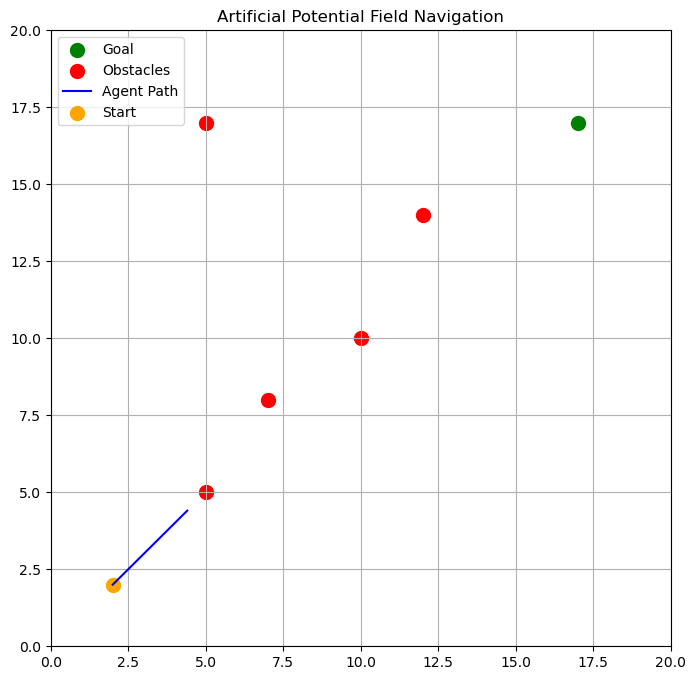

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the artificial potential field
def attractive_potential(pos, goal, zeta=1.0):
    """Attractive potential (pulls agent toward goal)"""
    return 0.5 * zeta * np.linalg.norm(pos - goal) ** 2

def attractive_force(pos, goal, zeta=1.0):
    """Attractive force derived from the attractive potential"""
    return -zeta * (pos - goal)

def repulsive_potential(pos, obstacle, eta=100.0, Q=1.0):
    """Repulsive potential (pushes agent away from obstacles)"""
    dist = np.linalg.norm(pos - obstacle)
    if dist <= Q:
        return 0.5 * eta * ((1.0 / dist - 1.0 / Q) ** 2)
    else:
        return 0

def repulsive_force(pos, obstacle, eta=100.0, Q=1.0):
    """Repulsive force derived from the repulsive potential"""
    dist = np.linalg.norm(pos - obstacle)
    if dist <= Q:
        return eta * (1.0 / dist - 1.0 / Q) * (1.0 / dist ** 3) * (pos - obstacle)
    else:
        return np.array([0.0, 0.0])

def total_force(pos, goal, obstacles):
    """Compute the total force acting on the agent at a given position"""
    total_f = attractive_force(pos, goal)
    for obs in obstacles:
        total_f += repulsive_force(pos, obs)
    return total_f

# Environment setup
grid_size = (20, 20)
start = np.array([2, 2])
goal = np.array([17, 17])
obstacles = np.array([[5, 5], [10, 10], [12, 14], [5, 17], [7, 8]])  # Example obstacle locations

# Simulation parameters
max_iterations = 1000
epsilon = 0.1  # Step size
threshold = 0.5  # Distance to goal to stop

# Initialize position
pos = start.copy()
trajectory = [pos.copy()]  # Store the trajectory for visualization

# Planning loop using artificial potential field
for i in range(max_iterations):
    force = total_force(pos, goal, obstacles)
    pos = pos + epsilon * force / np.linalg.norm(force)
    trajectory.append(pos.copy())
    
    # Stop if the agent reaches the goal
    if np.linalg.norm(pos - goal) < threshold:
        print(f"Reached goal in {i} iterations")
        break

# Visualization
trajectory = np.array(trajectory)

plt.figure(figsize=(8, 8))
plt.grid(True)
plt.xlim(0, grid_size[0])
plt.ylim(0, grid_size[1])
plt.scatter(goal[0], goal[1], color='green', label="Goal", s=100)
plt.scatter(obstacles[:, 0], obstacles[:, 1], color='red', label="Obstacles", s=100)
plt.plot(trajectory[:, 0], trajectory[:, 1], color='blue', label="Agent Path")
plt.scatter(start[0], start[1], color='orange', label="Start", s=100)
plt.legend()
plt.title('Artificial Potential Field Navigation')
plt.show()
